In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import pandas as pd
import tqdm

### Load datasets

In [2]:
## load images and labels
csv_path ='./data_csv/'# the path to svae the labels and tables 
def load_and_resize(image_path, image_size, normalized = True):
    image = Image.open(image_path).resize([image_size, image_size],Image.BILINEAR)
    if normalized:
        return np.array(image).astype(np.float32) / (255.0*255.0)
    else:
        return np.array(image).astype(np.float32)

    # load training
x_train = []
y_train = []
data_type = 'train'
label_list = pd.DataFrame(pd.read_csv(csv_path + 'crop_' + data_type + '_labels.csv'))
for i in range(len(label_list)):
    if (label_list['Benign'][i])|(label_list['Cancer'][i]): 
        img_read = load_and_resize(label_list['img_path'][i],image_size = 224, normalized = True)
        label = [label_list['Normal'][i]|label_list['Actionable'][i], label_list['Benign'][i]|label_list['Cancer'][i]]
        for j in range(10):
            x_train.append(img_read)
            y_train.append(label) 
    else:
        x_train.append(load_and_resize(label_list['img_path'][i],image_size = 224, normalized = True))
        y_train.append([label_list['Normal'][i]|label_list['Actionable'][i], label_list['Benign'][i]|label_list['Cancer'][i]]) 
        #y_train.append([label_list['Benign'][i],label_list['Cancer'][i]]) 

        # load validation
data_type = 'val'
label_list = pd.DataFrame(pd.read_csv(csv_path + 'crop_'+ data_type + '_labels.csv'))
x_val = []
y_val = []
for i in range(len(label_list)):
    if (label_list['Benign'][i])|(label_list['Cancer'][i]):
        img_read = load_and_resize(label_list['img_path'][i],image_size = 224, normalized = True)
        label = [label_list['Normal'][i]|label_list['Actionable'][i],  label_list['Benign'][i]|label_list['Cancer'][i]]
        for j in range(5):
            x_val.append(img_read)
            y_val.append(label) 
    else:
        x_val.append(load_and_resize(label_list['img_path'][i],image_size = 224, normalized = True))
        y_val.append([label_list['Normal'][i]|label_list['Actionable'][i], label_list['Benign'][i]|label_list['Cancer'][i]]) 
    #y_val.append([label_list['Benign'][i],label_list['Cancer'][i]]) 

# load testing
data_type = 'test'
label_list = pd.DataFrame(pd.read_csv(csv_path + 'crop_'+ data_type + '_labels.csv'))
x_test = []
y_test = []
for i in range(len(label_list)):
    x_test.append(load_and_resize(label_list['img_path'][i],image_size = 224, normalized = True))
    y_test.append([label_list['Normal'][i]|label_list['Actionable'][i],  label_list['Benign'][i]|label_list['Cancer'][i]]) 
    #y_test.append([label_list['Benign'][i],label_list['Cancer'][i]]) 

In [3]:
## shuffle the dataset
x_train, x_val, x_test = np.array(x_train).astype(np.float64), np.array(x_val).astype(np.float64), np.array(x_test).astype(np.float64)
y_train, y_val, y_test = np.argmax(np.array(y_train).astype(np.int64), axis=-1), np.argmax(np.array(y_val).astype(np.int64), axis=-1), np.argmax(np.array(y_test).astype(np.int64), axis=-1)
train_indice = np.arange(len(x_train))

np.random.shuffle(train_indice)
x_train = np.squeeze(x_train[train_indice])
y_train = np.squeeze(y_train[train_indice])


val_indice = np.arange(len(x_val))
np.random.shuffle(val_indice)
x_val = np.squeeze(x_val[val_indice])
y_val = np.squeeze(y_val[val_indice])

In [4]:
print(x_train.shape,y_train.shape)

(4636, 224, 224) (4636,)


In [5]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.hist(y_train)
plt.title('Training set')
plt.xlabel('Label')
plt.ylabel('Num')
plt.subplot(1,3,2)
plt.hist(y_val)
plt.title('Validation set')
plt.xlabel('Label')
plt.ylabel('Num')
plt.subplot(1,3,3)
plt.hist(y_test)
plt.title('Test set')
plt.xlabel('Label')
plt.ylabel('Num')

Text(0,0.5,'Num')

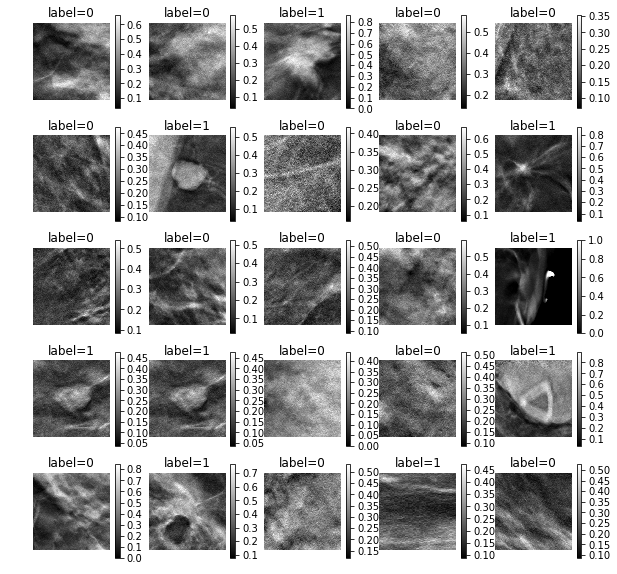

In [6]:
## plot the raw images to show
def plot_raw_images(batch,label):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :],cmap = 'gray')
        plt.colorbar()
        plt.title('label='+str(label[i]))
        plt.axis('off')
    plt.show()
plot_raw_images(x_train[:25,:,:],y_train[:25])

In [8]:
class Le_net(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # define the layers
        self.conv1 = tf.keras.layers.Conv2D(
        filters = 6,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        
        # step 2 pooling
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=[2, 2], strides=2)
        
        self.conv2 = tf.keras.layers.Conv2D(
        filters = 16,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        
        # step 4 pooling
        self.pool2 = tf.keras.layers.AveragePooling2D(pool_size=[2, 2], strides=2)
        
        self.flatten = tf.keras.layers.Reshape(target_shape=(16 * 56 * 56,))
        self.dense1 = tf.keras.layers.Dense(units=120, activation =tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=84, activation =tf.nn.relu)
        self.dense1 = tf.keras.layers.Dense(units=2)
        
    def call(self, inputs):
        # define the network structure
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
model = Le_net()

## a. train with basic model, clean image

In [14]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables   ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
def gray_to_rgb(images):
    """
    change the gray image to rgb image
    """
    width, height = images.shape[1], images.shape[2]
    rgb_image = np.empty((images.shape[0],width, height, 3), dtype=np.uint8)
    rgb_image[:, :, :, 2] = rgb_image[:,:,:, 1] = rgb_image[:, :, :, 0] = images
    return rgb_image.astype(np.double)-0.5
def expand_dims(images):
    return np.expand_dims(images, axis = 3)

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((expand_dims(x_train), y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((expand_dims(x_val), y_val)).batch(64)

In [19]:
EPOCHS = 15
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('raw_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: raw_model/assets
Epoch 1, Loss: 0.4856663644313812, Accuracy: 79.65918731689453, Val Loss: 0.55687016248703, Val Accuracy: 74.82014465332031
INFO:tensorflow:Assets written to: raw_model/assets
Epoch 2, Loss: 0.4298112094402313, Accuracy: 82.20448303222656, Val Loss: 0.5217646956443787, Val Accuracy: 77.26618957519531
INFO:tensorflow:Assets written to: raw_model/assets
Epoch 3, Loss: 0.3897896409034729, Accuracy: 84.27523803710938, Val Loss: 0.46392205357551575, Val Accuracy: 82.01438903808594
Epoch 4, Loss: 0.36062875390052795, Accuracy: 86.6048355102539, Val Loss: 0.5530074238777161, Val Accuracy: 74.67625427246094
Epoch 5, Loss: 0.3442760705947876, Accuracy: 87.07937622070312, Val Loss: 0.4301307797431946, Val Accuracy: 79.85611724853516
Epoch 6, Loss: 0.30883824825286865, Accuracy: 88.82657623291016, Val Loss: 0.4294876754283905, Val Accuracy: 81.87049865722656
Epoch 7, Loss: 0.2942819595336914, Accuracy: 89.58153533935547, Val Loss: 0.446909546852

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

## b train with low quality data, added noise

In [10]:
import random
def addsalt_pepper(img, SNR):
    img_ = img.copy()
    h, w = img_.shape
    proportion =  random.random()*0.2+0.4
    mask = np.random.choice((0, 1, 2), size=(h, w), p=[SNR, (1 - SNR) / 2. * proportion, 1-SNR- (1 - SNR) / 2. * proportion])    
    img_[mask == 1] = 1    # salt noise
    img_[mask == 2] = 0      # pepper noise
    return img_

def add_gauss(img,std=.2):
    noise_sig = np.random.normal(size = img.shape, scale = std)
    img = noise_sig + img
    img[img<0] = 0
    img[img>1] = 1
    return img
def add_noise_list(images,SNR):
    '''
    add gaussion noise and salt and pepper noise
    '''
    images_ = images.copy()
    for i in range(images.shape[0]):
        img = images[i]
        images_[i] = add_gauss(addsalt_pepper(img,SNR))
    return images_

x_train_noise = add_noise_list(x_train,0.5)
x_val_noise = add_noise_list(x_val,0.5)
x_test_noise = add_noise_list(x_test,0.5)

In [11]:
## plot the noisy images to show
def plot_raw_images(batch,label):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :],cmap = 'gray')
        plt.colorbar()
        plt.title('label='+str(label[i]))
        plt.axis('off')
    plt.show()
plot_raw_images(x_train_noise[:25,:,:],y_train[:25])

In [14]:
model = Le_net()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables   ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((expand_dims(x_train_noise), y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((expand_dims(x_val_noise), y_val)).batch(64)
EPOCHS = 15
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds: 
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: noise_model/assets
Epoch 1, Loss: 0.7481900453567505, Accuracy: 52.04917907714844, Val Loss: 0.6374830603599548, Val Accuracy: 77.98561096191406
INFO:tensorflow:Assets written to: noise_model/assets
Epoch 2, Loss: 0.5915840268135071, Accuracy: 68.7446060180664, Val Loss: 0.49146509170532227, Val Accuracy: 78.41726684570312
INFO:tensorflow:Assets written to: noise_model/assets
Epoch 3, Loss: 0.48408958315849304, Accuracy: 77.89041900634766, Val Loss: 0.44023096561431885, Val Accuracy: 80.43165588378906
Epoch 4, Loss: 0.44616392254829407, Accuracy: 80.99655151367188, Val Loss: 0.4639318585395813, Val Accuracy: 78.56114959716797
Epoch 5, Loss: 0.4251645505428314, Accuracy: 81.94564056396484, Val Loss: 0.4741939306259155, Val Accuracy: 80.43165588378906
Epoch 6, Loss: 0.40130457282066345, Accuracy: 83.9516830444336, Val Loss: 0.45752429962158203, Val Accuracy: 79.85611724853516
Epoch 7, Loss: 0.38888028264045715, Accuracy: 84.08110809326172, Val Loss: 0.5

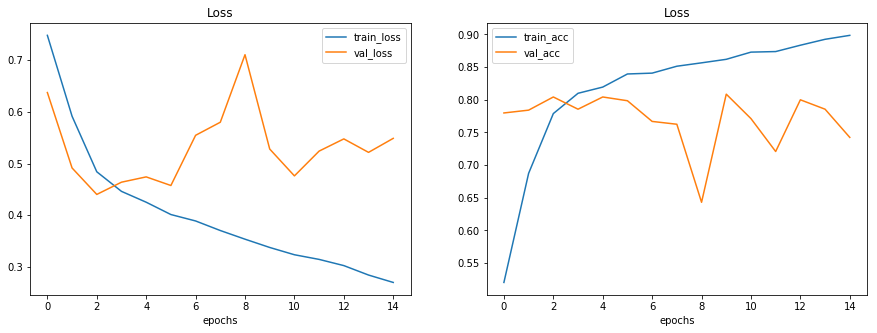

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### Use R to control physical layer

In [92]:
### add physical layer, add an filter at aperture layer
# we assume the sample only contains different absorption without phase delay
x_train_sample = 1 - x_train_noise
aperture_r =  tf.Variable(initial_value=0.001, dtype=tf.float32, trainable = True, constraint = lambda p : tf.clip_by_value(p,0,0.008), name = 'aperture_r')
weight_init = tf.random_normal_initializer()
#aperture_filter =  tf.Variable(initial_value=tf.ones(shape=(224,224), dtype=tf.float32), trainable = True, constraint = lambda p : tf.clip_by_value(p,0,1), name = 'aperture_r')
num_samples = 224
fx = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
fy = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
fxx, fyy = tf.meshgrid(fx,fy)
dist = tf.sqrt((fxx)**2+(fyy)**2)

In [93]:
def physical_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    input_ill = tf.cast(tf.ones(x_batch_sample.shape), tf.float32)
    input_ill = tf.cast(tf.multiply(input_ill, x_batch_sample), tf.complex64)
    cir_aper = tf.cast(tf.nn.relu(tf.nn.tanh(aperture_r*11200-dist)), dtype = tf.complex64)
  # your aperture mask (circular aperture and phase), then propagate it to the
  # image plane;
    circle = tf.cast(tf.tile(cir_aper[tf.newaxis,...] , multiples = [x_batch.shape[0],1,1]) , dtype = tf.complex64)
    f_x = tf.signal.fftshift(tf.signal.fft2d(input_ill))
    cir_x = tf.multiply(circle, f_x)
    det_x = tf.signal.ifft2d(tf.signal.ifftshift(cir_x))
  # if you didn't already, add color channel singleton dimension in preparation
  # for processing through a CNN:
    img_inten = tf.cast(det_x, dtype = tf.float32)
    image = img_inten[..., tf.newaxis]
    return image-0.5
class Le_net(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # define the layers
        self.conv1 = tf.keras.layers.Conv2D(
        filters = 16,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        self.conv2 = tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        # step 3 pooling
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        
        self.conv3 = tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        self.conv4 = tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = [5, 5],
        padding ='same',
        activation =tf.nn.relu
        )
        # step 6 pooling
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(32 * 56 * 56,))
        self.dense1 = tf.keras.layers.Dense(units=8)
        
    def call(self, inputs):
        # define the network structure
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x
model = Le_net()
def forward_model(x_batch):
    p_layer_out = physical_layer(x_batch)
    return model(p_layer_out)

In [94]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables + [aperture_r]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 15
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('filter_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: filter_noise_model/assets
Epoch 1, Loss: 0.676611065864563, Accuracy: 62.79119873046875, Val Loss: 0.485090434551239, Val Accuracy: 76.25899505615234
INFO:tensorflow:Assets written to: filter_noise_model/assets
Epoch 2, Loss: 0.5155277848243713, Accuracy: 76.91976165771484, Val Loss: 0.43458080291748047, Val Accuracy: 81.87049865722656
Epoch 3, Loss: 0.44902896881103516, Accuracy: 80.73770141601562, Val Loss: 0.437301367521286, Val Accuracy: 80.5755386352539
Epoch 4, Loss: 0.42305609583854675, Accuracy: 81.924072265625, Val Loss: 0.45032912492752075, Val Accuracy: 78.99280548095703
Epoch 5, Loss: 0.3976043462753296, Accuracy: 83.52027893066406, Val Loss: 0.4605664312839508, Val Accuracy: 79.56834411621094
Epoch 6, Loss: 0.39013436436653137, Accuracy: 84.1242446899414, Val Loss: 0.6839770674705505, Val Accuracy: 74.2446060180664
Epoch 7, Loss: 0.37698423862457275, Accuracy: 84.5340805053711, Val Loss: 0.5271556377410889, Val Accuracy: 70.50360107421875

#### plot the trained r, and the images after physical layer

tf.Tensor(
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]], shape=(224, 224), dtype=complex64)


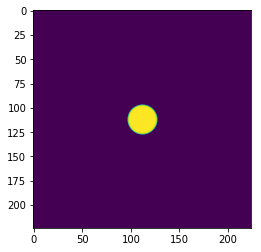

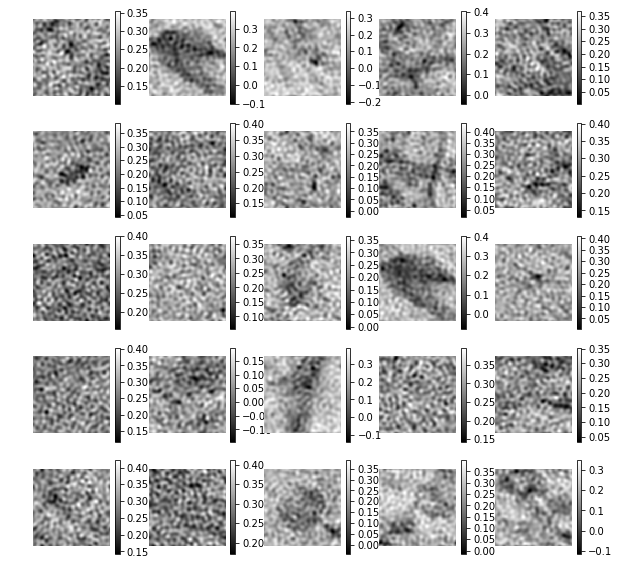

In [104]:
def physical_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    input_ill = tf.cast(tf.ones(x_batch_sample.shape), tf.float32)
    input_ill = tf.cast(tf.multiply(input_ill, x_batch_sample), tf.complex64)
    cir_aper = tf.cast(tf.nn.relu(tf.nn.tanh(aperture_r*11200-dist)), dtype = tf.complex64)
    print(cir_aper)
  # your aperture mask (circular aperture and phase), then propagate it to the
  # image plane;
    circle = tf.cast(tf.tile(cir_aper[tf.newaxis,...] , multiples = [x_batch.shape[0],1,1]) , dtype = tf.complex64)
    plt.imshow(np.abs(cir_aper))
    f_x = tf.signal.fftshift(tf.signal.fft2d(input_ill))
    cir_x = tf.multiply(circle, f_x)
    det_x = tf.signal.ifft2d(tf.signal.ifftshift(cir_x))
  # if you didn't already, add color channel singleton dimension in preparation
  # for processing through a CNN:
    img_inten = tf.cast(det_x, dtype = tf.float32)
    image = img_inten[..., tf.newaxis]
    return image-0.5
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0], cmap = 'gray')
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(physical_layer(x_train_noise[:25]).numpy())

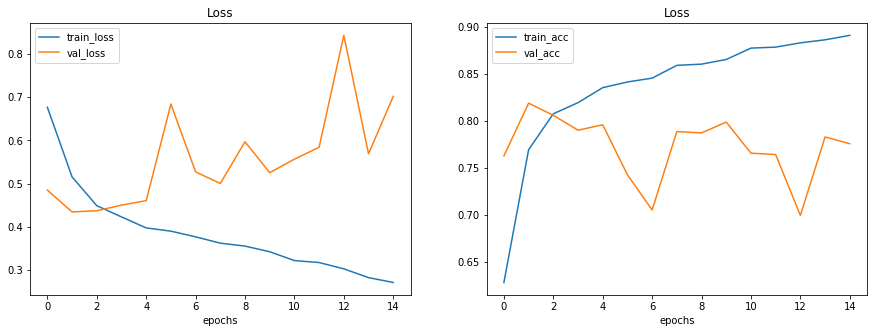

In [105]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### determined R, optimized apterture filter

In [33]:
### add physical layer, add an filter at aperture layer
# we assume the sample only contains different absorption without phase delay
x_train_sample = 1 - x_train_noise
weight_init = tf.random_normal_initializer()
aperture_filter =  tf.Variable(initial_value=tf.ones(shape=(224,224), dtype=tf.float32)*0.5, trainable = True, constraint = lambda p : tf.clip_by_value(p,0,1), name = 'aperture_filter')
num_samples = 224
fx = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
fy = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
fxx, fyy = tf.meshgrid(fx,fy)
dist = tf.sqrt((fxx)**2+(fyy)**2)
r = 30
cir_aper = tf.cast(dist<=r, dtype = tf.float32)
def physical_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    input_ill = tf.cast(tf.ones(x_batch_sample.shape), tf.float32)
    input_ill = tf.cast(tf.multiply(input_ill, x_batch_sample), tf.complex64)
  # your aperture mask (circular aperture and phase), then propagate it to the
  # image plane;
    circle = tf.cast(tf.tile((cir_aper*aperture_filter)[tf.newaxis,...] , multiples = [x_batch.shape[0],1,1]) , dtype = tf.complex64)
    f_x = tf.signal.fftshift(tf.signal.fft2d(input_ill))
    cir_x = tf.multiply(circle, f_x)
    det_x = tf.signal.ifft2d(tf.signal.ifftshift(cir_x))
  # if you didn't already, add color channel singleton dimension in preparation
  # for processing through a CNN:
    img_inten = tf.cast(det_x, dtype = tf.float32)
    image = img_inten[..., tf.newaxis]
    return image-0.5
model = Le_net()
def forward_model(x_batch):
    p_layer_out = physical_layer(x_batch)
    return model(p_layer_out)

In [34]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables + [aperture_filter]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 10
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('filter2_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: filter2_noise_model/assets
Epoch 1, Loss: 0.8659034371376038, Accuracy: 51.876617431640625, Val Loss: 0.6309453248977661, Val Accuracy: 67.19424438476562
INFO:tensorflow:Assets written to: filter2_noise_model/assets
Epoch 2, Loss: 0.6486997008323669, Accuracy: 69.99568176269531, Val Loss: 0.44964978098869324, Val Accuracy: 80.71942138671875
INFO:tensorflow:Assets written to: filter2_noise_model/assets
Epoch 3, Loss: 0.5296191573143005, Accuracy: 77.07074737548828, Val Loss: 0.4342244267463684, Val Accuracy: 81.43885040283203
Epoch 4, Loss: 0.49057331681251526, Accuracy: 78.23554992675781, Val Loss: 0.4780900180339813, Val Accuracy: 81.15107727050781
Epoch 5, Loss: 0.4467381536960602, Accuracy: 81.14753723144531, Val Loss: 0.7199888825416565, Val Accuracy: 71.07913208007812
Epoch 6, Loss: 0.4284883737564087, Accuracy: 82.35548400878906, Val Loss: 0.4755050837993622, Val Accuracy: 79.56834411621094
Epoch 7, Loss: 0.37904176115989685, Accuracy: 84.188957

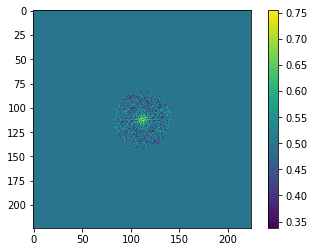

In [35]:
plt.imshow(aperture_filter)
plt.colorbar()

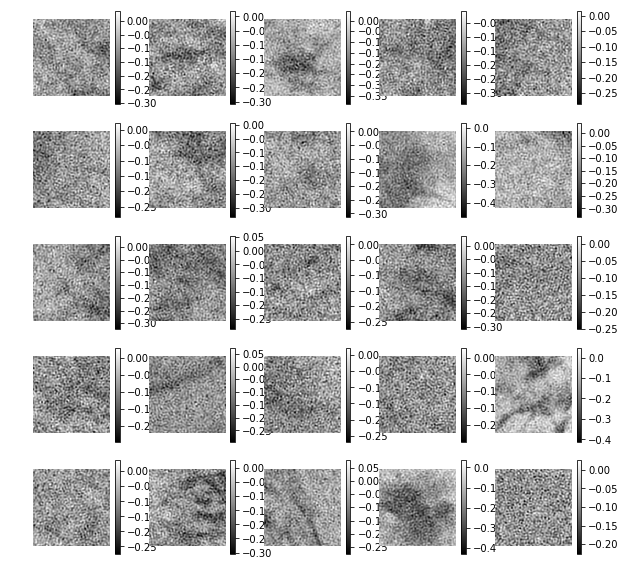

In [40]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0], cmap = 'gray')
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(physical_layer(x_train_noise[:25]).numpy())

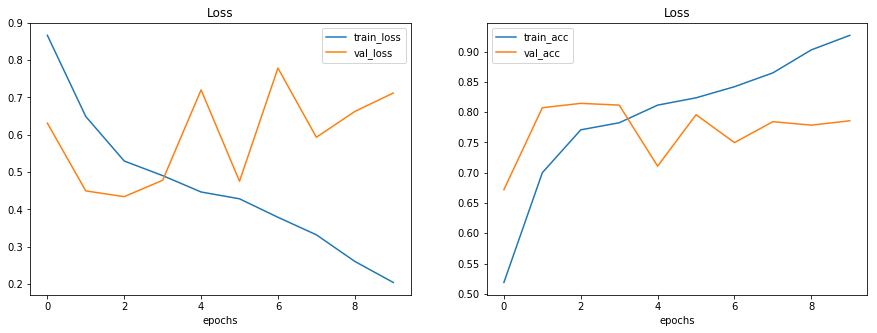

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### add illumination layer to influence

In [50]:
### add physical layer, add an filter at aperture layer
# we assume the sample only contains different absorption without phase delay
x_train_sample = 1 - x_train_noise
weight_init = tf.random_normal_initializer()
ill_layer =  tf.Variable(initial_value=tf.ones(shape=(224,224), dtype=tf.float32), trainable = True, name = 'illumination')
num_samples = 224
cir_aper = tf.cast(dist<=r, dtype = tf.float32)
def illumination_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    input_ill = tf.cast(tf.multiply(tf.tile(ill_layer[tf.newaxis,...],multiples = [x_batch.shape[0],1,1]), x_batch_sample),  tf.float32)
    return input_ill
model = Le_net()
def forward_model(x_batch):
    p_layer_out = illumination_layer(x_batch)
    return model(p_layer_out[..., tf.newaxis])

In [51]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables + [ill_layer]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 10
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('filter2_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: filter2_noise_model/assets
Epoch 1, Loss: 1.0412129163742065, Accuracy: 50.776527404785156, Val Loss: 0.6963607668876648, Val Accuracy: 46.04316711425781
INFO:tensorflow:Assets written to: filter2_noise_model/assets
Epoch 2, Loss: 0.7475132346153259, Accuracy: 53.968936920166016, Val Loss: 0.5189123749732971, Val Accuracy: 79.1366958618164
Epoch 3, Loss: 0.6276490092277527, Accuracy: 67.88179016113281, Val Loss: 0.5350220799446106, Val Accuracy: 74.10072326660156
Epoch 4, Loss: 0.545983076095581, Accuracy: 74.65487670898438, Val Loss: 0.48110198974609375, Val Accuracy: 78.56114959716797
Epoch 5, Loss: 0.5191264152526855, Accuracy: 78.06298828125, Val Loss: 0.8198792934417725, Val Accuracy: 70.93524932861328
Epoch 6, Loss: 0.4492270052433014, Accuracy: 80.95340728759766, Val Loss: 0.7285670638084412, Val Accuracy: 77.69784545898438
Epoch 7, Loss: 0.41370323300361633, Accuracy: 83.21829223632812, Val Loss: 0.6088046431541443, Val Accuracy: 69.7841720581

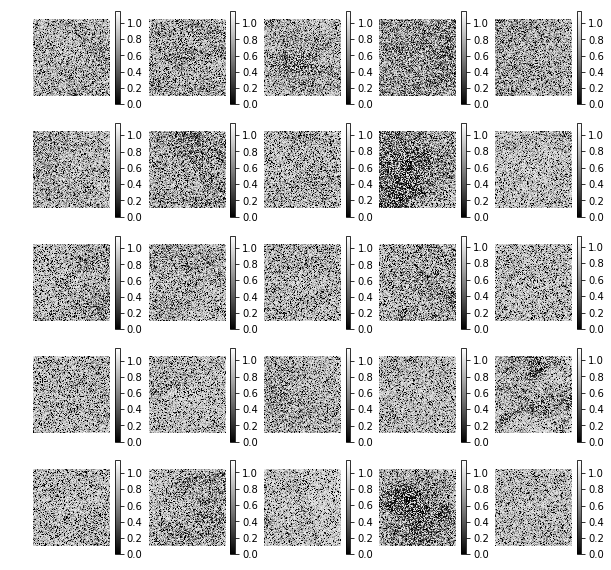

In [52]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0], cmap = 'gray')
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(illumination_layer(x_train_noise[:25])[..., tf.newaxis].numpy())

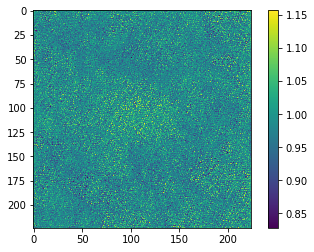

In [53]:
plt.imshow(ill_layer)
plt.colorbar()

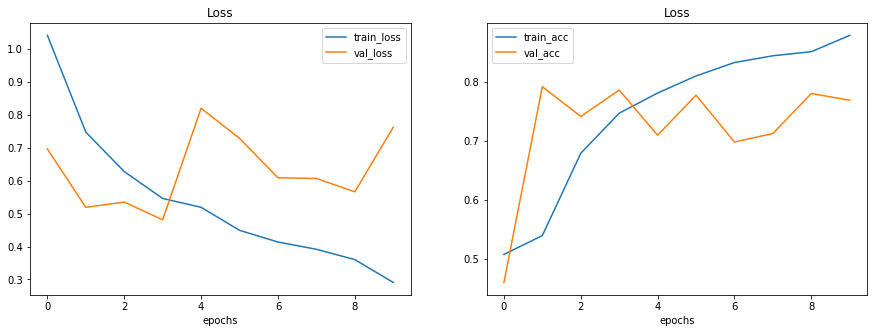

In [54]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### determined R, illmination

In [14]:
x_train_sample = 1 - x_train_noise
weight_init = tf.random_normal_initializer()
ill_layer =  tf.Variable(initial_value=tf.ones(shape=(224,224), dtype=tf.float32), trainable = True, name = 'illumination')
num_samples = 224
x = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
y = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
xx, yy = tf.meshgrid(x,y)
dist = tf.sqrt((xx)**2+(yy)**2)
r = 50
cir_aper = tf.cast(dist<=r, dtype = tf.float32)
def illumination_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    ill_circle = (ill_layer*cir_aper)[tf.newaxis,...]
    input_ill = tf.cast(tf.multiply(tf.tile(ill_circle,multiples = [x_batch.shape[0],1,1]), x_batch_sample),  tf.float32)
    return input_ill
model = Le_net()
def forward_model(x_batch):
    p_layer_out = illumination_layer(x_batch)
    return model(p_layer_out[..., tf.newaxis])

In [15]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables + [ill_layer]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 10
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('ill1_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: ill1_noise_model/assets
Epoch 1, Loss: 0.8405300378799438, Accuracy: 50.90595626831055, Val Loss: 0.6832709312438965, Val Accuracy: 53.95683670043945
Epoch 2, Loss: 0.7140259146690369, Accuracy: 52.73942947387695, Val Loss: 0.712551474571228, Val Accuracy: 53.95683670043945
INFO:tensorflow:Assets written to: ill1_noise_model/assets
Epoch 3, Loss: 0.690961480140686, Accuracy: 59.18895721435547, Val Loss: 0.6394147276878357, Val Accuracy: 63.30935287475586
INFO:tensorflow:Assets written to: ill1_noise_model/assets
Epoch 4, Loss: 0.6384888887405396, Accuracy: 66.50129699707031, Val Loss: 0.4943579435348511, Val Accuracy: 76.40287780761719
INFO:tensorflow:Assets written to: ill1_noise_model/assets
Epoch 5, Loss: 0.5918644070625305, Accuracy: 70.59965515136719, Val Loss: 0.45141544938087463, Val Accuracy: 79.56834411621094
Epoch 6, Loss: 0.6020179390907288, Accuracy: 71.07420349121094, Val Loss: 0.5362895727157593, Val Accuracy: 73.52517700195312
Epoch 7, 

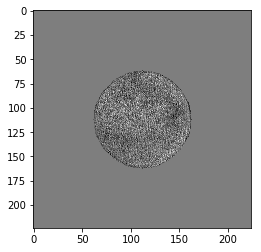

In [27]:
plt.imshow((ill_layer-1)*10, cmap = 'gray')

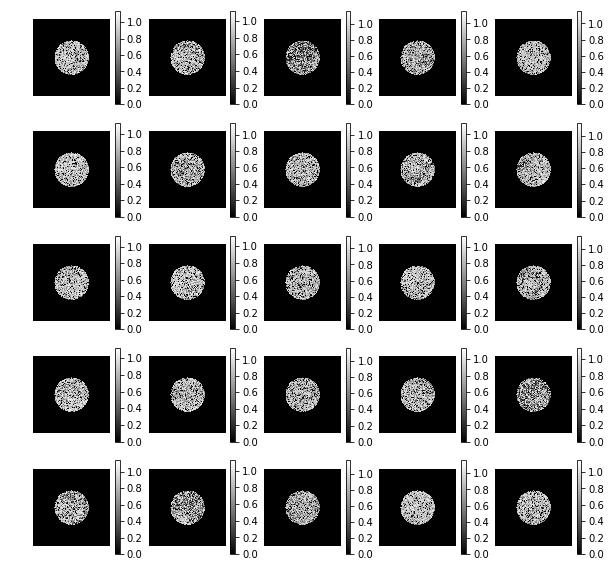

In [17]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0], cmap = 'gray')
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(illumination_layer(x_train_noise[:25])[..., tf.newaxis].numpy())

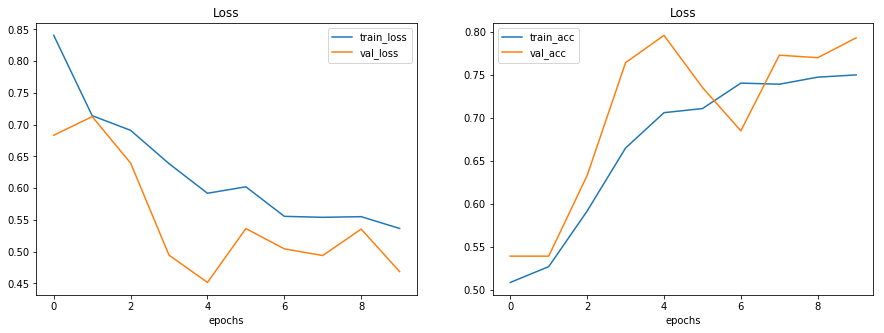

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### optimized R

In [37]:
ill_r =  tf.Variable(initial_value=0.8, dtype=tf.float32, trainable = True, constraint = lambda p : tf.clip_by_value(p,0,1), name = 'ill_r')
num_samples = 224
x = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
y = tf.linspace(-num_samples/2, num_samples/2-1, num = num_samples)
xx, yy = tf.meshgrid(x,y)
dist = tf.sqrt((xx)**2+(yy)**2)
def illumination_layer(x_batch):
  # x_batch is a batch of phase-only objects that we created earlier;
  # propagate the field emerging from these objects to the Fourier plane, apply
    x_batch_sample = tf.cast(1 - x_batch, tf.float32)
    ill_circle = tf.cast(tf.nn.relu(tf.nn.tanh(ill_r*112-dist)), dtype = tf.float32)[tf.newaxis,...]
    input_ill = tf.cast(tf.multiply(tf.tile(ill_circle,multiples = [x_batch.shape[0],1,1]), x_batch_sample),  tf.float32)
    return input_ill
model = Le_net()
def forward_model(x_batch):
    p_layer_out = illumination_layer(x_batch)
    return model(p_layer_out[..., tf.newaxis])

In [38]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables = model.trainable_variables + [ill_r]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 10
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the startii of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('ill_r_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: ill_r_noise_model/assets
Epoch 1, Loss: 1.4920871257781982, Accuracy: 50.28041458129883, Val Loss: 0.7365841269493103, Val Accuracy: 53.95683670043945
Epoch 2, Loss: 0.7567692399024963, Accuracy: 53.386539459228516, Val Loss: 0.8329677581787109, Val Accuracy: 46.04316711425781
INFO:tensorflow:Assets written to: ill_r_noise_model/assets
Epoch 3, Loss: 0.7044872641563416, Accuracy: 61.410701751708984, Val Loss: 0.48293083906173706, Val Accuracy: 81.00719451904297
INFO:tensorflow:Assets written to: ill_r_noise_model/assets
Epoch 4, Loss: 0.6215891242027283, Accuracy: 68.46419525146484, Val Loss: 0.46083566546440125, Val Accuracy: 81.29496765136719
Epoch 5, Loss: 0.5679558515548706, Accuracy: 72.9723892211914, Val Loss: 0.48880302906036377, Val Accuracy: 75.10791778564453
Epoch 6, Loss: 0.5853882431983948, Accuracy: 72.58412170410156, Val Loss: 0.5459697842597961, Val Accuracy: 73.52517700195312
Epoch 7, Loss: 0.5441429615020752, Accuracy: 75.474548339843

In [33]:
# the full forward model, which includes both the physical layer and the CNN model:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
        train_variables =  [ill_r]  ## the training variables
        #print(model.trainable_variables )
    gradients = tape.gradient(loss, train_variables)
    optimizer.apply_gradients(zip(gradients, train_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_noise, y_val)).batch(64)
EPOCHS = 10
val_acc_best = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
    val_loss_list.append(test_loss.result())
    val_acc_list.append(test_accuracy.result())
    # save the model
    if test_accuracy.result()>val_acc_best:
        val_acc_best = test_accuracy.result()
        model.save('ill_r_noise_model')
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result() * 100}'
  )

INFO:tensorflow:Assets written to: ill_r_noise_model/assets
Epoch 1, Loss: 0.48044177889823914, Accuracy: 79.55133819580078, Val Loss: 0.48811662197113037, Val Accuracy: 77.553955078125
Epoch 2, Loss: 0.4779990315437317, Accuracy: 79.59447479248047, Val Loss: 0.48812153935432434, Val Accuracy: 77.553955078125
Epoch 3, Loss: 0.47674697637557983, Accuracy: 79.24935150146484, Val Loss: 0.4897327721118927, Val Accuracy: 76.54676818847656
Epoch 4, Loss: 0.4777474105358124, Accuracy: 79.61604309082031, Val Loss: 0.48954200744628906, Val Accuracy: 77.41007232666016
Epoch 5, Loss: 0.47898295521736145, Accuracy: 79.40034484863281, Val Loss: 0.4920181334018707, Val Accuracy: 76.9784164428711
Epoch 6, Loss: 0.47787004709243774, Accuracy: 78.99050903320312, Val Loss: 0.4997522234916687, Val Accuracy: 76.40287780761719
Epoch 7, Loss: 0.47731536626815796, Accuracy: 79.50819396972656, Val Loss: 0.4961915910243988, Val Accuracy: 76.9784164428711
Epoch 8, Loss: 0.4757504463195801, Accuracy: 79.48662567

In [34]:
ill_r

<tf.Variable 'ill_r:0' shape=() dtype=float32, numpy=0.76276433>

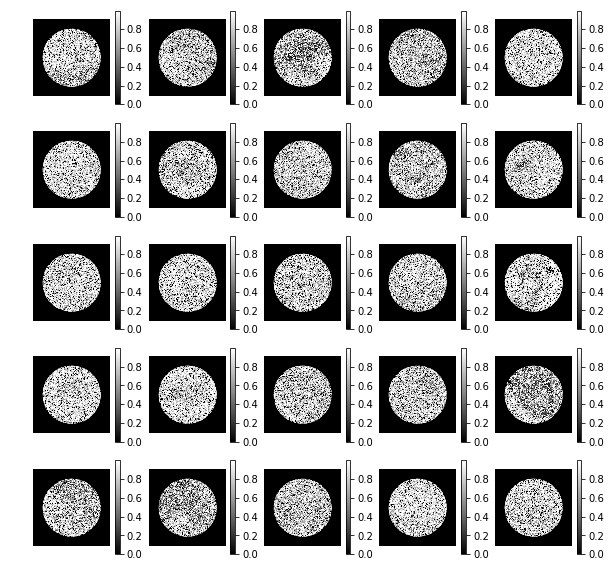

In [35]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0], cmap = 'gray')
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(illumination_layer(x_train_noise[:25])[..., tf.newaxis].numpy())

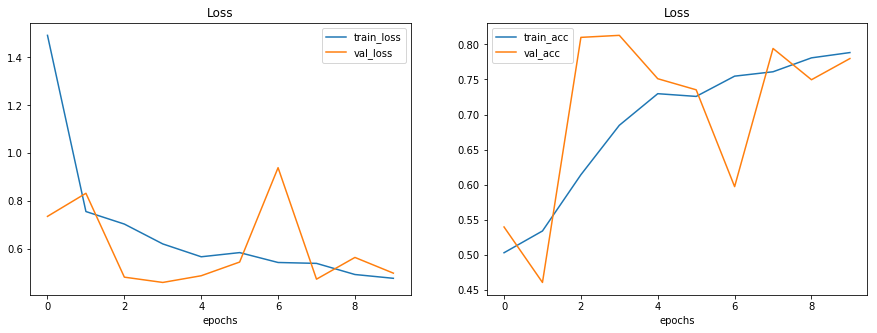

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

### Teast results

### clean model

In [63]:
from sklearn.metrics import confusion_matrix

In [52]:
forward_model = tf.keras.models.load_model('raw_model')

In [53]:
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    pred.append(tf.argmax(predictions, axis=-1))
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [55]:
x_test_noise = add_noise_list(x_test,0.5)
test_ds = tf.data.Dataset.from_tensor_slices((expand_dims(x_test_noise), y_test)).batch(64)

In [73]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model

In [74]:
test_accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.77435064>

In [75]:
pred = np.array(pred).flat

/home/hanxue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


### noise model

In [80]:
forward_model = tf.keras.models.load_model('noise_model')

In [81]:
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions =  forward_model(images)
    #print(tf.argmax(predictions, axis=-1),labels)
    pred.append(tf.argmax(predictions, axis=-1))
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [82]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model

In [83]:
test_accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.84090906>

### physical 1 model

In [84]:
forward_model = tf.keras.models.load_model('filter_noise_model')

In [85]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model

In [86]:
test_accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.77922076>

### physical 2 model

In [87]:
forward_model = tf.keras.models.load_model('filter2_noise_model')

In [88]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model

### physical 3 model

In [91]:
forward_model = tf.keras.models.load_model('ill1_noise_model')

In [92]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model

### physical 4 model

In [94]:
forward_model = tf.keras.models.load_model('ill_r_noise_model')

In [95]:
pred =[]
test_loss.reset_states()
test_accuracy.reset_states()
for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    # save the model